In [1]:
import os

import numpy as np
from ml_collections import config_dict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

from tn_generative import *

from tn_generative.train_configs import surface_code_train_config_optimization
from tn_generative import run_data_generation

# from tn_generative.train_configs import 
from tn_generative import run_training

HOME = os.path.expanduser('~')

In [2]:
from jax import config as jax_config

jax_config.update('jax_enable_x64', True)

In [3]:
# import importlib
# types = importlib.reload(types)
# lattices = importlib.reload(lattices)
# node_collections = importlib.reload(node_collections)
# physical_systems = importlib.reload(physical_systems)
# data_generation = importlib.reload(data_generation)
# mps_sampling = importlib.reload(mps_sampling)


In [4]:
TASK_REGISTRY = data_generation.TASK_REGISTRY
REG_REGISTRY = regularizers.REGULARIZER_REGISTRY

# Run training. x, z bases

In [5]:
TASK_NAME = 'surface_code'
data_dir = f"{HOME}/tn_shadow_dir/Data/{TASK_NAME}/" # Google drive path to save data locally
dataset_name = '66325485_surface_code_x_or_z_basis_sampler_system_size=7_d=60_onsite_z_field=0.000.nc'
ds = xr.open_dataset(data_dir + dataset_name)
ds = data_utils.combine_complex_ds(ds)

In [6]:
#@title Sweep over bond dimension and dataset size
def sweep_sc_3x3_fn():
  # 5x5 sites surface code sweep
  for d in [5, 10]:
    for num_training_samples in [5000, 10_000, 30_000, 50_000]:
      for reg in [0., 1., 5., 10., 100.]:
        yield {'model.bond_dim': d,
               'data.num_training_samples': num_training_samples,
               'training.reg_kwargs.beta': reg,
               }


def sweep_sc_7x7_fn():
  # 7x7 sites surface code sweep
  for d in [10, 20]:
    for num_training_samples in [500, 5000]:
      yield {'model.bond_dim': d,
             'data.num_training_samples': num_training_samples,
             }

sweep_params = list(sweep_sc_7x7_fn())

SWEEP_FN_REGISTRY = {
    'sweep_sc_7x7_fn': list(sweep_sc_7x7_fn())
}

In [7]:
def get_experiment_config():
  config = config_dict.ConfigDict()
  config.model = config_dict.ConfigDict()
  config.model.bond_dim = 10
  config.model.dtype = 'complex64'
  config.model.init_seed = 42
  # data.
  config.data = config_dict.ConfigDict()
  config.data.num_training_samples = 10_000
  config.data.dir = f'{HOME}/tn_shadow_dir/Data/{TASK_NAME}' 
  config.data.filename = '66325485_surface_code_x_or_z_basis_sampler_system_size=7_d=60_onsite_z_field=0.000.nc'
  # sweep.
  config.sweep_name = config_dict.placeholder(str)
  config.sweep_fn_registry = SWEEP_FN_REGISTRY  
  # training.
  config.training = config_dict.ConfigDict()
  config.training.num_training_steps = 200
  config.training.opt_kwargs = {}
  config.training.reg_name = 'none'
  config.training.reg_kwargs = {} # {'beta': 0., 'estimator': 'mps'}
  # Save options.
  config.results = config_dict.ConfigDict()
  config.results.save_results = False
  config.results.experiment_dir = ''.join([
      f'{HOME}/tn_shadow_dir/Results', '/Tests/%CURRENT_DATE/']
  )
  config.results.filename = '%JOB_ID_%TASK_ID'  
  return config

In [8]:
all_train_dfs = []
all_eval_dfs = []
all_mps_results = []
for id, sweep_param in enumerate(sweep_params):
  config = get_experiment_config()
  config.update_from_flattened_dict(sweep_param)
  train_df, eval_df, final_mps = run_training.run_full_batch_experiment(config)
  train_df['id'] = id
  eval_df['id'] = id
  all_train_dfs.append(train_df)
  all_eval_dfs.append(eval_df)
  all_mps_results.append(final_mps)

+nan [best: +26.421171651757] :  87%|████████▋ | 174/200 [00:26<00:04,  6.46it/s]            
+31.004102508841 [best: +31.004102508841] : : 202it [01:05,  3.07it/s]                       
+nan [best: +22.961924046439] : : 334it [00:43,  7.74it/s]                                   
+29.120576864308 [best: +29.120576864308] : : 205it [01:44,  1.96it/s]                       


In [9]:
full_eval_df = pd.concat(all_eval_dfs)
full_train_df = pd.concat(all_train_dfs)

In [10]:
full_eval_df

,fidelity,model_ll,target_ll,sweep_name,data_dir,data_filename,data_num_training_samples,model_bond_dim,model_dtype,model_init_seed,results_experiment_dir,results_filename,results_save_results,training_num_training_steps,training_reg_name,id
0,2.600622e-07,26.42117165091647,28.671340761457888,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
0,5.759204e-07,31.004102389477314,28.62947423894118,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,1
0,1.828531e-07,22.9619240464387,28.671340761457888,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,2
0,1.210865e-06,29.120576864308312,28.62947423894118,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,3


In [14]:
full_train_df

,loss,opt_step,sweep_name,data_dir,data_filename,data_num_training_samples,model_bond_dim,model_dtype,model_init_seed,results_experiment_dir,results_filename,results_save_results,training_num_training_steps,training_reg_name,id
0,36.790493,0.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
1,35.719536,1.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
2,35.209133,2.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
3,34.674465,3.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
4,34.460461,4.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,500,10,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,29.133354,200.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,3
201,29.130831,201.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,3
202,29.127335,202.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,3
203,29.126272,203.0,None,/Users/yan/tn_shadow_dir/Data/surface_code,66325485_surface_code_x_or_z_basis_sampler_sys...,5000,20,complex64,42,/Users/yan/tn_shadow_dir/Results/Tests/%CURREN...,%JOB_ID_%TASK_ID,False,200,none,3


In [20]:
full_train_df.fillna(0., inplace=True)

# Evaluation visualization

In [11]:
full_eval_df['infidelity'] = 1 - full_eval_df['fidelity']
full_eval_df['data_misfit'] = (full_eval_df['model_ll'] - full_eval_df['target_ll']) / full_eval_df['target_ll'].mean()
full_eval_df['data_misfit'] = full_eval_df['data_misfit'].astype(float)

In [18]:
def lineplot_breaknans(data, break_at_nan=True, break_at_inf=True, **kwargs):
    '''sns.lineplot by default doesn't break the line at nans or infs, 
        which can lead to misleading plots.
    See https://github.com/mwaskom/seaborn/issues/1552 
        and https://stackoverflow.com/questions/52098537/avoid-plotting-missing-values-on-a-line-plot
    
    This function rectifies this, and allows the user to specify 
        if it should break the line at nans, infs, or at both (default).
    
    Note: using this function means you can't use the `units` argument of sns.lineplot.'''

    cum_num_nans_infs = np.zeros(len(data))
    if break_at_nan: cum_num_nans_infs += np.cumsum(np.isnan(data[kwargs['y']]))
    if break_at_inf: cum_num_nans_infs += np.cumsum(np.isinf(data[kwargs['y']]))
    sns.lineplot(data, **kwargs, units=cum_num_nans_infs, 
            estimator=None)  #estimator must be None when specifying units

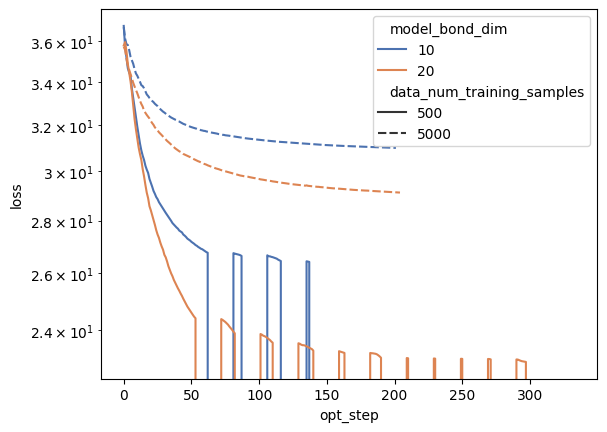

In [21]:
#@title Training visualization

sns.lineplot(
    full_train_df,
    x='opt_step',
    y='loss',
    style='data_num_training_samples',
    hue='model_bond_dim',
    palette='deep',
)
plt.yscale('log')
plt.show()

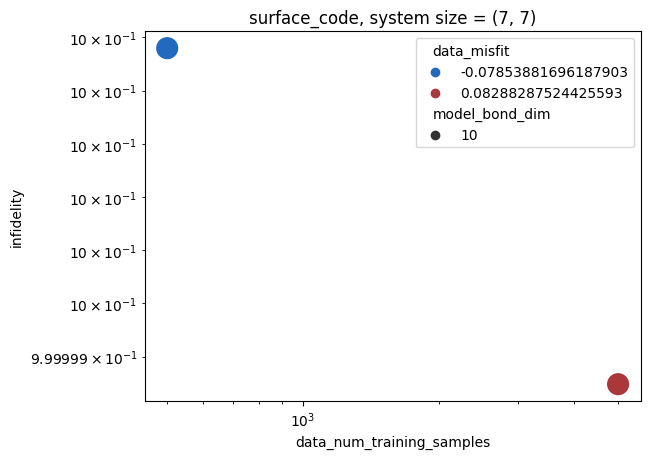

In [26]:
#@title Eval visualization

sns.scatterplot(
    full_eval_df.query('model_bond_dim == 10'),
    x='data_num_training_samples',
    y='infidelity',
    style='model_bond_dim',
    hue='data_misfit',
    s=300,
    palette='vlag',
)
plt.xscale('log')
plt.yscale('log')
plt.title(f'{TASK_NAME}, system size = {ds.size_x, ds.size_y}')
plt.show()